In [1]:
import glob
import os
import warnings
import scanpy as sc
import pandas as pd
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt

In [2]:
warnings.simplefilter(action="ignore")
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, figsize=(5, 4.5))

In [9]:
adata = sc.read_h5ad("./02adata_bbknnall.h5ad")

In [10]:
adata.obs["tissue"]

GSM4909253_AAACCTGAGACTAGGC-1        Normal
GSM4909253_AAACCTGAGGACAGAA-1        Normal
GSM4909253_AAACCTGAGGATGTAT-1        Normal
GSM4909253_AAACCTGCAAGAGGCT-1        Normal
GSM4909253_AAACCTGGTAGCTTGT-1        Normal
                                    ...    
GSM4909317_TTTGTTGGTCTCTCCA-1    ER+ tumour
GSM4909317_TTTGTTGGTGGGTATG-1    ER+ tumour
GSM4909317_TTTGTTGTCGCACGGT-1    ER+ tumour
GSM4909317_TTTGTTGTCTCCCTAG-1    ER+ tumour
GSM4909317_TTTGTTGTCTCGGTAA-1    ER+ tumour
Name: tissue, Length: 266862, dtype: category
Categories (6, object): ['ER+ tumour', 'HER2+ tumour', 'Normal', 'PR+ tumour', 'Triple negative BRCA1 tumour', 'Triple negative tumour']

In [11]:
adata = adata.raw.to_adata()
adata.raw = adata

In [12]:
print(f"{adata.X.min()}\n{adata.X.max()}") 

0.0
9.020427703857422


In [13]:
adata.obs["celltype2"] = adata.obs["celltype"].to_list()

In [14]:
index = (adata.obs["celltype2"] == "Epithelial") & (adata.obs["type"] == "Tumor")
adata.obs['celltype2'][index] = 'Malignant'

In [15]:
adata = adata[adata.obs["celltype"] == "Epithelial",:]

In [16]:
import infercnvpy as cnv

In [17]:
gtf_file = "/home/maomin/material/Supp/gencode.v46.annotation.gtf.gz"

In [18]:
cnv.io.genomic_position_from_gtf(gtf_file, adata=adata, gtf_gene_id='gene_name', inplace=True)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [19]:
cnv.tl.infercnv(adata=adata,
    reference_key="celltype2",
    reference_cat=['Epithelial'],
    window_size=250)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.14it/s]


In [21]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

computing PCA
    with n_comps=50
    finished (0:00:25)
computing neighbors
    finished: added to `.uns['cnv_neighbors']`
    `.obsp['cnv_neighbors_distances']`, distances for each pair of neighbors
    `.obsp['cnv_neighbors_connectivities']`, weighted adjacency matrix (0:01:02)
running Leiden clustering
    finished: found 32 clusters and added
    'cnv_leiden', the cluster labels (adata.obs, categorical) (0:05:18)


In [22]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:10)


... storing 'celltype2' as categorical
... storing 'gene_id' as categorical
... storing 'gene_name' as categorical


<Axes: title={'center': 'type'}, xlabel='cnv_umap1', ylabel='cnv_umap2'>

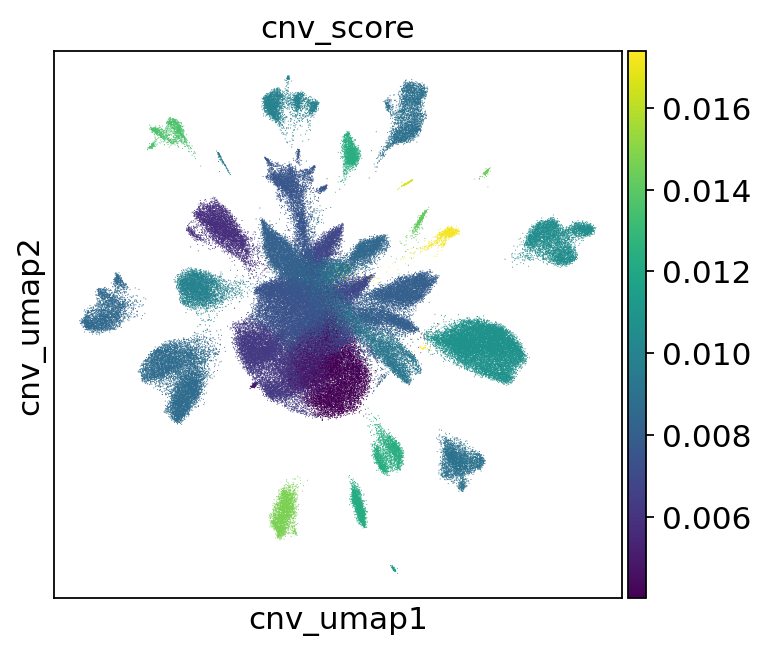

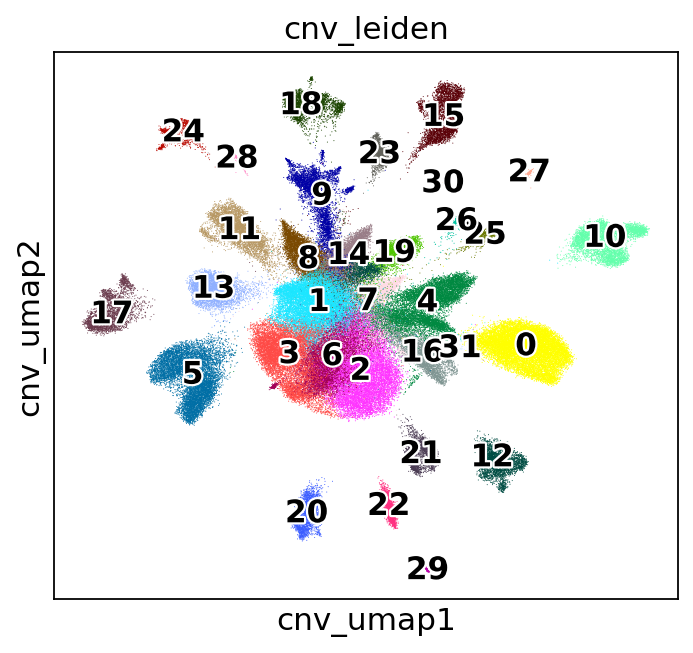

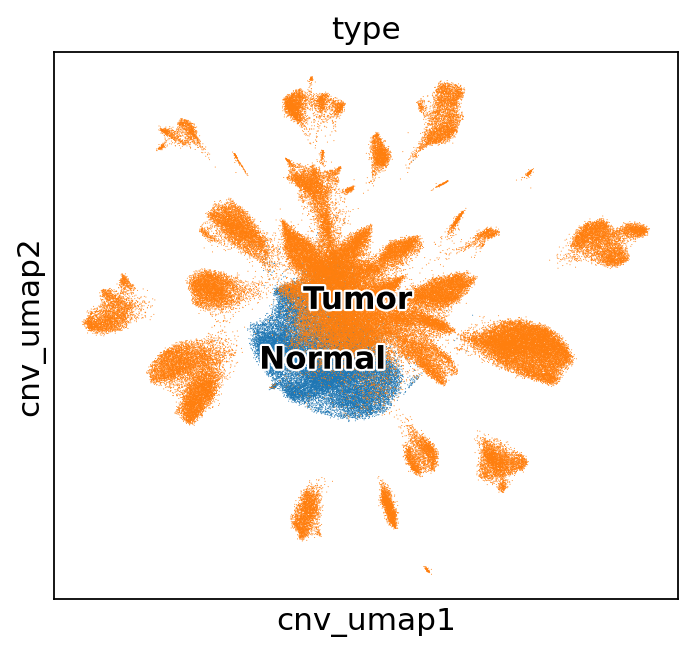

In [23]:
cnv.pl.umap(adata,color=["cnv_score"],legend_loc="on data",legend_fontoutline=2,show=False,)
cnv.pl.umap(adata,color=["cnv_leiden"],legend_loc="on data",legend_fontoutline=2,show=False,)
cnv.pl.umap(adata,color=["type"],legend_loc="on data",legend_fontoutline=2,show=False,)

In [27]:
adata.obs["cnv_status"] = "Epithelial"
adata.obs.loc[adata.obs["cnv_leiden"].isin(['17','5','20','22','29','21','12','0','10','25','26',
                                           '30','27','15','23','31','18','28','24','5','13']), "cnv_status"] = "Malignant"

In [28]:
adata.obs.groupby('cnv_status')['type'].value_counts()

cnv_status  type  
Epithelial  Tumor     58307
            Normal    30799
Malignant   Tumor     57807
            Normal       54
Name: count, dtype: int64

In [29]:
adata.write_h5ad("./03adata_infercnvall.h5ad", compression="gzip")

... storing 'cnv_status' as categorical


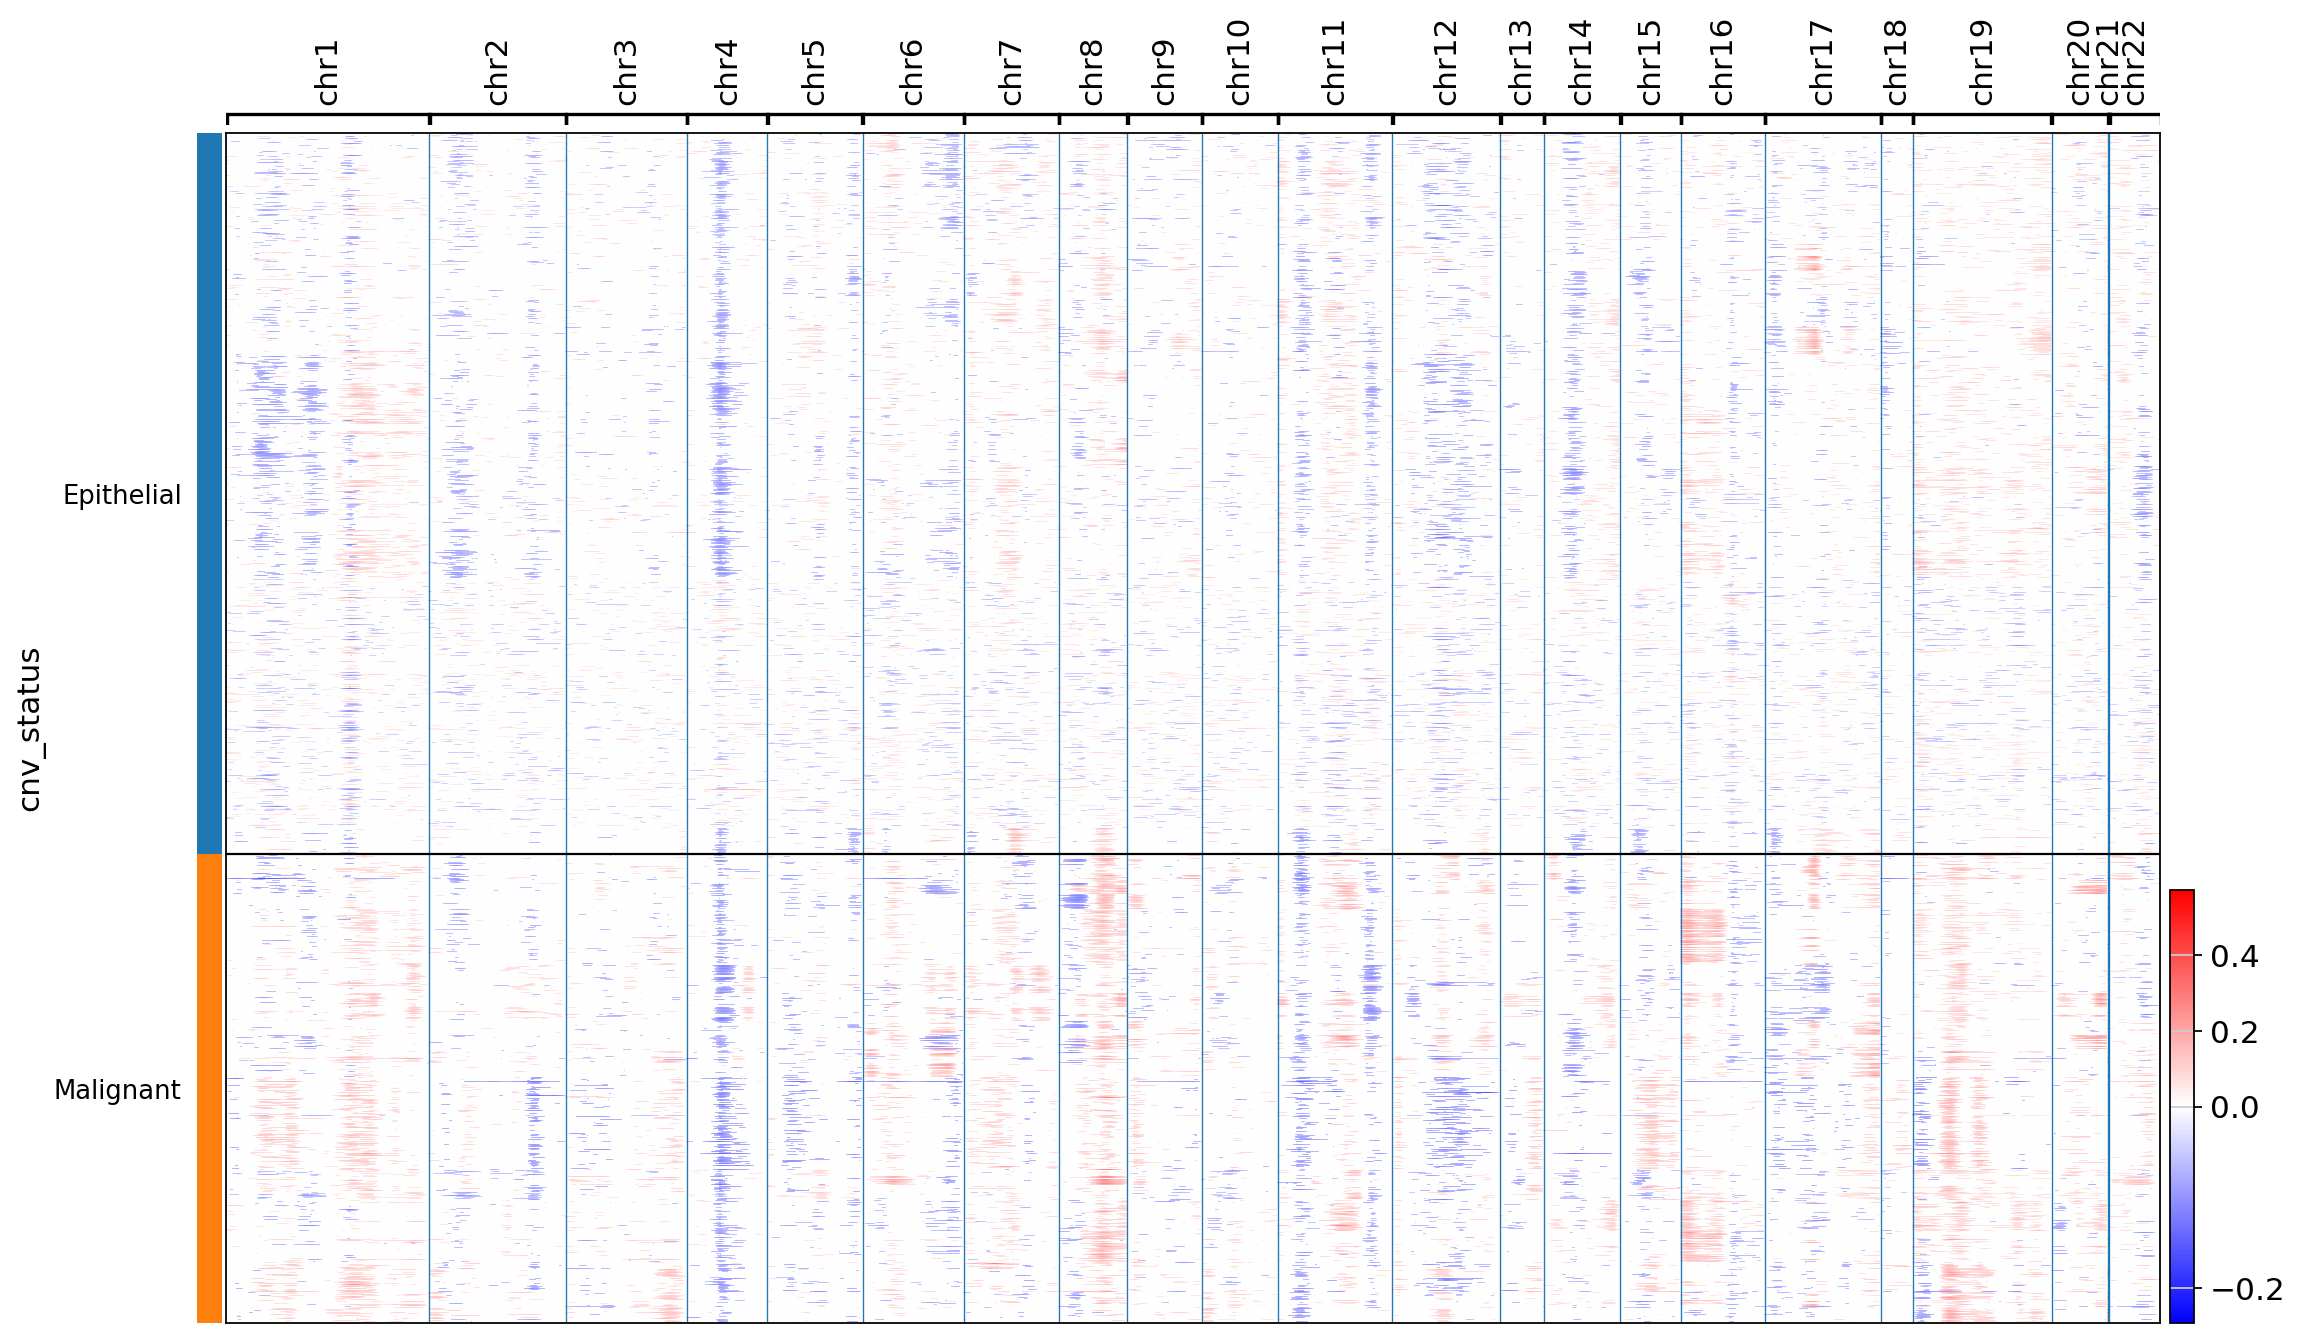

In [32]:
cnv.pl.chromosome_heatmap(adata,groupby='cnv_status',save=True)